In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalTrees
from src.evals.eval_trees import EvalCntrees

# Args

In [41]:
corr = 0.0
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")
fignum = '10'
recalc_results = False

epoch=32-val_loss=0.000378.ckpt


In [48]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models", "layer6")
fignum = '11'
recalc_results = False

epoch=33-val_loss=0.000662.ckpt


# Load Model and Dataset

In [49]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

n_eval_envs = 50
is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


/tmp/ipykernel_2420436/2030544574.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Helper Functions

In [56]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

def make_pca_plots(hidden_states, reward_idx, layers, figname=None, dims=[0,1]):
    n_layers = len(hidden_states)
    fig, axs = plt.subplots(1, n_layers, figsize=(2.5, 0.9))
    s_multiplier = 1 if n_layers==3 else 0.25

    for layer in range(n_layers):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token

        # Perform PCA
        pca = PCA(n_components=100)
        data_pca = pca.fit_transform(data)
        data_pca = data_pca / np.abs(data_pca).max(axis=0)
        
        # Plot the points
        pt_mask = np.ones(len(data_pca), dtype=bool)
        pt_mask[reward_idx] = False
        _layers = np.array(layers)
        axs[layer].scatter(
            data_pca[pt_mask, dims[0]], data_pca[pt_mask, dims[1]],
            c=_layers[pt_mask], cmap='plasma', s=5*s_multiplier,
            alpha=0.8)
        axs[layer].scatter(
            data_pca[reward_idx, dims[0]], data_pca[reward_idx, dims[1]],
            c='red', s=10*s_multiplier,
            alpha=1., marker='*')

        axs[layer].set_aspect('equal', 'box')
        axs[layer].set_box_aspect(1)
        axs[layer].set_xticks([])
        axs[layer].set_yticks([])
        for spine in axs[layer].spines.values():
            spine.set_visible(True)
    plt.tight_layout(pad=0.2, w_pad=0.5)
    os.makedirs(f'figs_app/C_{fignum}', exist_ok=True)
    if figname is not None:
        plt.savefig(f'figs_app/C_{fignum}/' + figname + '.png', transparent=True, dpi=300)
        plt.savefig(f'figs_app/C_{fignum}/' + figname + '.pdf', transparent=True, dpi=300)
    plt.show()


# Make visualization plots

Sequence Length: 1


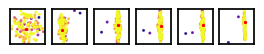

Sequence Length: 800


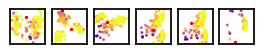

Sequence Length: 1


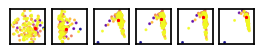

Sequence Length: 800


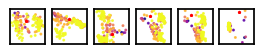

Sequence Length: 1


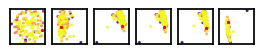

Sequence Length: 800


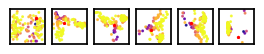

Sequence Length: 1


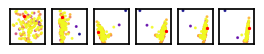

Sequence Length: 800


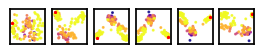

In [57]:
for i_eval in range(4):
    traj = eval_trajs[i_eval]
    env_config = {
        'max_layers': 7,
        'horizon': 1600,
        'branching_prob': 1.0,
        'node_encoding_corr': corr,
        'state_dim': state_dim,
        'initialization_seed': np.array(traj['initialization_seed']).item()
    }
    env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
    layers = []
    positions = []
    state_features = []
    state_features = list(env.node_map.keys())
    
    for state_feature in state_features:
        layers.append(env.node_map[state_feature].layer)
        positions.append(env.node_map[state_feature].pos)
    
    reward_idx = np.argwhere([np.all(s == env.goal) for s in state_features]).item()
    
    seq_lengths = [1, 800]
    for seq_length in seq_lengths:
        print(f'Sequence Length: {seq_length}')
        hidden_states = run_model(traj, model, state_features, seq_length)
        figname = f'{i_eval}_{seq_length}'
        make_pca_plots(hidden_states, reward_idx, layers, figname)
        hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
        del hidden_states
        torch.cuda.empty_cache()

# Make summary plots

In [58]:
def get_kernel_alignment(K_A, K_B):
    # Center the kernel matrices
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

dist_func = lambda data: squareform(pdist(data, metric='correlation'))
def get_dist_metric(hidden_states, true_dist_matrix, gamma, random_ctrl=False):
    kas = []
    dist_matrices = []
    K_input = gamma**true_dist_matrix # exponential kernel

    for layer in range(len(hidden_states)):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        if random_ctrl:
            np.random.shuffle(data)

        representation_dist_matrix = dist_func(data)
        clip_val = np.percentile(representation_dist_matrix, 99)
        representation_dist_matrix = np.clip(representation_dist_matrix, None, clip_val)
        representation_dist_matrix = representation_dist_matrix / representation_dist_matrix.max()

        data -= data.mean(0)[None,:]
        K_latents = data @ data.T
        kernel_alignment = get_kernel_alignment(K_input, K_latents)
        kas.append(kernel_alignment)
        dist_matrices.append(representation_dist_matrix)
    return kas, dist_matrices

In [59]:
if recalc_results:
    dist_results = {
        'seq_length': [],
        'layer': [],
        'diff': [],
        'diff_no_reward': [],
        'random_diff': [],
        'gamma': []
    }
    baseline_dist_results = {
        'diff': [],
        'gamma': []
    }
    
    for i_eval in range(n_eval_envs):
        traj = eval_trajs[i_eval]
    
        first_reward = np.argwhere(np.array(traj['context_rewards'])>0)
        if (first_reward.size == 0) or (first_reward[0] > 600):
            continue
    
        env_config = {
            'max_layers': 7,
            'horizon': 1600,
            'branching_prob': 1.0,
            'node_encoding_corr': corr,
            'state_dim': state_dim,
            'initialization_seed': np.array(traj['initialization_seed']).item()
        }
        env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
        layers = []
        positions = []
        state_features = []
        state_features = list(env.node_map.keys())
    
        for state_feature in state_features:
            layers.append(env.node_map[state_feature].layer)
            positions.append(env.node_map[state_feature].pos)
    
        true_dist_matrix = []
    
        for state_feature in state_features:
            _, dist_from_state = env._make_opt_action_dict(state_feature)
            sorted_dist_from_state = []
            for state_feature in state_features:
                sorted_dist_from_state.append(dist_from_state[state_feature])
            true_dist_matrix.append(sorted_dist_from_state)
    
        true_dist_matrix = np.array(true_dist_matrix)
    
        for seq_length in [1, 25, 50, 75, 100, 250, 500, 750, 800, 1000]:
            hidden_states = run_model(traj, model, state_features, seq_length)
            hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
            for gamma in np.arange(0.1, 1., 0.1):
                diffs, dist_matrices = get_dist_metric(hidden_states, true_dist_matrix, gamma)
                random_diffs, _ = get_dist_metric(hidden_states, true_dist_matrix, gamma, random_ctrl=True)
                diffs_no_reward, _ = get_dist_metric(hidden_states_no_reward, true_dist_matrix, gamma)
                dist_results['seq_length'].extend([seq_length] * model.n_layer)
                dist_results['layer'].extend(range(model.n_layer))
                dist_results['diff'].extend(diffs)
                dist_results['random_diff'].extend(random_diffs)
                dist_results['diff_no_reward'].extend(diffs_no_reward)
                dist_results['gamma'].extend([gamma] * model.n_layer)
            # Clear GPU memory
            del hidden_states
            del hidden_states_no_reward
            torch.cuda.empty_cache()

        # Get baseline kernel alignment from input features
        gamma = 0.6
        state_features_tensor = np.array(state_features)
        state_features_tensor -= state_features_tensor.mean(0)[None,:]
        K_latents = state_features_tensor @ state_features_tensor.T
        K_input = gamma**true_dist_matrix 
        kernel_alignment = get_kernel_alignment(K_input, K_latents)
        baseline_dist_results['diff'].append(kernel_alignment)
        baseline_dist_results['gamma'].append(gamma)

    dist_results = pd.DataFrame(dist_results)
    baseline_dist_results = pd.DataFrame(baseline_dist_results)
    with open(f'pickles/AppC_fig{fignum}_kernel_alignment_summary.pkl', 'wb') as f:
       pickle.dump(
           {'dist_results': dist_results, 'baseline_dist_results': baseline_dist_results},
           f)
else:
    with open(f'pickles/AppC_fig{fignum}_kernel_alignment_summary.pkl', 'rb') as f:
        r = pickle.load(f)
        dist_results = r['dist_results']
        baseline_dist_results = r['baseline_dist_results']

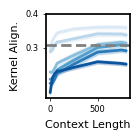

In [61]:
fig, ax = plt.subplots(figsize=(1.5, 1.5))
_dist_results = dist_results[dist_results['seq_length']<=800]
custom_blues = sns.color_palette("Blues", n_colors=model.n_layer)
sns.lineplot(
    data=_dist_results,
    x='seq_length', y='diff', hue='layer', palette=custom_blues,
    linewidth=2,
    ax=ax, legend=False)
ax.axhline(
    np.mean(baseline_dist_results['diff']),
    color='gray', linestyle='--',
    linewidth=2,
    label='Baseline'
)
label_fontsize = 8
tick_fontsize = 6
ax.set_xlabel('Context Length', fontsize=label_fontsize)
ax.set_ylabel('Kernel Align.', fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks([0.3, 0.4], fontsize=tick_fontsize)
ylims = ax.get_ylim()
plt.tight_layout()
plt.savefig(f'figs_app/C_{fignum}B.png', transparent=True, dpi=300)
plt.savefig(f'figs_app/C_{fignum}B.svg', transparent=True, dpi=300)
plt.show()